## HCP Eigen Modes notebook

In [1]:
%%capture --no-display

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, get_complex_laplacian

In [2]:
# this function needs to be incorporated into spectrome?
def get_meanC(Call):
    #C = np.mean(Call, axis = 2)
    C = (Call + np.transpose(Call))/2
    ss = np.sort(C[:])[::-1]
    C = np.minimum(C,ss[np.round(0.01*len(ss)).astype('int')])
    return C

In [3]:
# Some house keeping
hcp_dir = "/home/axiezai/lab/brain-scfc/spectrome/spectrome/data"

# Define frequency range of interest
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
# get the complex laplacian and its eigen modes:
f2w = np.abs(fvec-10).argmin() #8th index = alpha ~10hz
w = 2*np.pi*fvec[f2w]

# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load('/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/com_dk.npy').item()
DK_df_normalized = pd.read_csv('/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/DK_dictionary_normalized.csv').set_index('Unnamed: 0')
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
# Create FC network jupyter widget for visiualization
fc_names = ['Visual','Limbic', 'Default', 'Somatomotor', 'Frontoparietal', 'Ventral_Attention', 'Dorsal_Attention']

We need to threshold so that the amount of non-zero elements in the eigenmodes are similar to the support of the canonical networks they are being compared to. Plot the distribution of these canonical network's region-wise weights first.

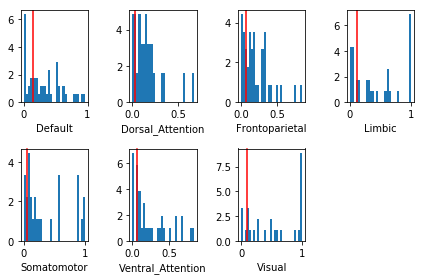

In [4]:
p = 1
for names in DK_df_normalized.index:
    y = np.nan_to_num(DK_df_normalized.loc[names].values)
    u = np.mean(y)
    s = np.std(y)
    plt.subplot(2,4,p)
    plt.hist(y[np.nonzero(y)], 30, density = True)
    plt.xlabel(names)
    plt.axvline(u-s*0.2, color = 'r')
    p += 1
    
plt.tight_layout()

In [5]:
xall = []
for names in DK_df_normalized.index:
    x = np.count_nonzero(DK_df_normalized.loc[names].values)
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[names].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[names].values))
    xall.append(x)
    print ("Number of non zeros elements in {} network is {}".format(names, x))
    print ("{} network's mean is {}".format(names,u))
    print ("{} network's standard deviation is {}".format(names,s))
    
print("Average number of non-zero elements is {}".format(np.mean(xall)))

Number of non zeros elements in Default network is 62
Default network's mean is 0.19331434987496474
Default network's standard deviation is 0.2572601143670553
Number of non zeros elements in Dorsal_Attention network is 36
Dorsal_Attention network's mean is 0.0528080257964081
Dorsal_Attention network's standard deviation is 0.1157064069215022
Number of non zeros elements in Frontoparietal network is 48
Frontoparietal network's mean is 0.09806281787307308
Frontoparietal network's standard deviation is 0.16885544819610704
Number of non zeros elements in Limbic network is 43
Limbic network's mean is 0.175685178720891
Limbic network's standard deviation is 0.3195720484960755
Number of non zeros elements in Somatomotor network is 35
Somatomotor network's mean is 0.11406184813409133
Somatomotor network's standard deviation is 0.2576382009425513
Number of non zeros elements in Ventral_Attention network is 45
Ventral_Attention network's mean is 0.10579581613816773
Ventral_Attention network's st

### Actually binarizing according to threshold

In [6]:
# binarize according to threshold:
#threshold, ub, lb = 0.2, 1, 0
ub, lb = 1, 0

DKfc_binarized = pd.DataFrame([], index=DK_df_normalized.index, columns=DK_df_normalized.columns)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u-s*0.1
    DKfc_binarized.loc[name]=np.where(DK_df_normalized.loc[name].values > threshold, ub, lb)
    print("Number of non-zero elements in {} network is {}".format(name, np.count_nonzero(DKfc_binarized.loc[name].values)))
    
DKfc_binarized

Number of non-zero elements in Default network is 32
Number of non-zero elements in Dorsal_Attention network is 22
Number of non-zero elements in Frontoparietal network is 29
Number of non-zero elements in Limbic network is 22
Number of non-zero elements in Somatomotor network is 22
Number of non-zero elements in Ventral_Attention network is 24
Number of non-zero elements in Visual network is 20


,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Default,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
Dorsal_Attention,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Frontoparietal,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Limbic,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
Somatomotor,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ventral_Attention,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Visual,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


## Creating HCP Brain object

In [7]:
HCP_brain = Brain.Brain()
HCP_brain.add_connectome(hcp_dir)
HCP_brain.reorder_connectome(HCP_brain.connectome, HCP_brain.distance_matrix)
HCP_brain.bi_symmetric_c()
HCP_brain.reduce_extreme_dir()
HCP_brain.add_laplacian_eigenmodes(HCP_brain.reducedConnectome, HCP_brain.distance_matrix, w=w, speed = 10, num_ev=86)
HCP_brain.norm_eigenmodes.shape

(86, 86)

#### Visualize both the connectome and eigenmodes:

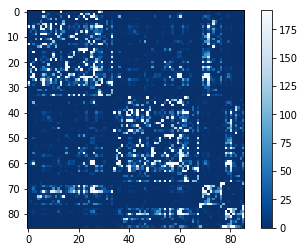

In [8]:
plt.imshow(HCP_brain.reducedConnectome, cmap=plt.cm.Blues_r)
plt.colorbar()

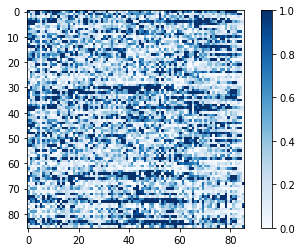

In [9]:
plt.imshow(HCP_brain.norm_eigenmodes,cmap=plt.cm.Blues)
plt.colorbar()

Text(0, 0.5, 'Eigen Values')

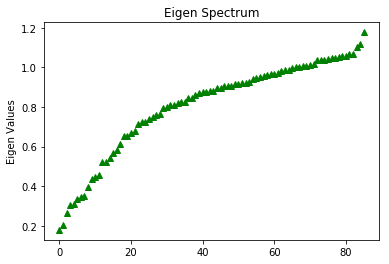

In [10]:
# plot eigen spectrum
plt.plot(np.abs(HCP_brain.eigenvalues),'g^')
plt.title('Eigen Spectrum')
plt.ylabel('Eigen Values')

In [11]:
## Replicate Ashish's polar coordinates plot:
def get_complex_eigenmodes(C, D, w, speed = 10):
    nroi = C.shape[0]
    # Get row degree and col degree, make extremely big connections inf
    rowdegree = np.transpose(np.sum(C,axis=1)) #row degrees
    coldegree = np.sum(C,axis=0) # column degrees
    qind = rowdegree + coldegree < 0.2*np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    Tau = 0.001*D/speed # delay as a function of distance and transmission speed
    Cc = C*np.exp(-1j*Tau*w) #Complex Laplacian
    
    # Compute Laplacian and decompose into eigen vectors
    L1 = 0.8*np.identity(nroi)
    L2 = np.divide(1,np.sqrt(np.multiply(rowdegree,coldegree))+np.spacing(1)) #diag(1./(sqrt(rowdegree.*coldegree)+eps));
    L = L1 - np.matmul(np.diag(L2),Cc) #Final Laplacian
    # decomposition with linalg.eig 
    K = nroi
    d, v = np.linalg.eig(L)
    # sorting in ascending & absolute value
    eig_ind = np.argsort(np.abs(d))
    eig_vec = v[:,eig_ind]
    #abseiv = np.abs(eig_vec[:,0])
    sorted_Evals = d[eig_ind]

    # defining some intermediate variables
    ev = np.transpose(sorted_Evals[0:K])
    Vv = eig_vec[:,0:K]
    Vvec = np.asarray(Vv)
    return ev, Vvec

In [12]:
ev, Vvec = get_complex_eigenmodes(HCP_brain.reducedConnectome, HCP_brain.distance_matrix, w=10)

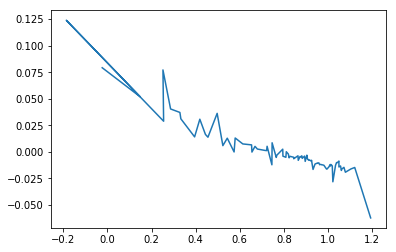

In [13]:
fig,ax = plt.subplots()
allreal = np.zeros([len(fvec),Vvec.shape[0]])
allimag = np.zeros([len(fvec),Vvec.shape[0]])
for f in np.arange(0,len(fvec)):
    ww = 2*np.pi*fvec[f]
    ev, Vvec = get_complex_eigenmodes(HCP_brain.reducedConnectome, HCP_brain.distance_matrix, w=ww)
    #ax.scatter(Vvec.real, Vvec.imag)
    allreal[f,:] = ev.real
    allimag[f,:] = ev.imag

ax.plot(allreal[2,:],allimag[2,:])

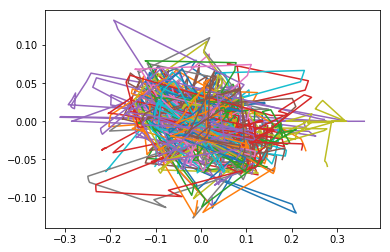

In [42]:
# calculate for all frequencies:
fig,ax = plt.subplots()
allreal = np.zeros([len(fvec),Vvec.shape[0],Vvec.shape[1]])
allimag = np.zeros([len(fvec),Vvec.shape[0],Vvec.shape[1]])
for f in np.arange(0,len(fvec)):
    ww = 2*np.pi*fvec[f]
    ev, Vvec = get_complex_eigenmodes(HCP_brain.reducedConnectome, HCP_brain.distance_matrix, w=ww)
    #ax.scatter(Vvec.real, Vvec.imag)
    allreal[f,:,:] = Vvec.real
    allimag[f,:,:] = Vvec.imag

ax.plot(allreal[:,:,1],allimag[:,:,1])
#fig,ax = plt.subplots()
#for f in np.arange(0,len(fvec)):
#    ax.plot(allreal[f,:,:],allimag[f,:,:])

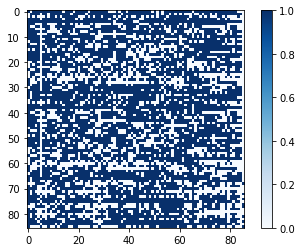

In [9]:
# binarize eigenmodes
HCP_brain.binary_eigenmodes = np.where(HCP_brain.norm_eigenmodes > threshold, ub, lb)
plt.imshow(HCP_brain.binary_eigenmodes, cmap=plt.cm.Blues)
plt.colorbar()

## Dice dissimilarity metric first:

In [10]:
# to do: 1) figure out row or column ordering for eigen modes, index it correctly in this function
def get_dice_df(x,y):
    """[Dice similarity score betewen two boolean arrays, then make it into a Pandas Dataframe
    translate into dataframes after we compute all the arrays?]
    
    Args:
        x ([array]): [eigen mode array with boolean array values]
        y ([Dataframe]): [canonical network data frame with boolean array vaues]

    Returns:
        dice_df [array]: dice scores between each eigen mode and each canonical network    
    """
    df_cols = y.index
    df_ind = ['Eig #%d' % x for x in np.arange(x.shape[1])+1]
    df_dice = pd.DataFrame([], index = df_ind, columns = df_cols)
    eigcounter = 0
    for eignum in df_dice.index:
        for name in y.index:
            em = x[:,eigcounter] #eigen mode values
            fc = y.loc[name].values
            #df_dice.at[eignum, name] = (distance.dice(em,fc)*np.count_nonzero(fc))
            df_dice.at[eignum,name] = distance.dice(em,fc) #without multiplying by support
        eigcounter += 1
    return df_dice

In [11]:
hcp_dice = get_dice_df(HCP_brain.binary_eigenmodes,DKfc_binarized)
hcp_dice.head(10).style.set_caption('HCP Eigenmode Dice Coef').apply(functions.highlight_min, axis=1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,0.586957,0.855072,0.818182,0.590361,0.813333,0.736842,0.580247
Eig #2,0.534884,0.873016,0.605634,0.454545,0.884058,0.8,0.6
Eig #3,0.617021,0.887324,0.746835,0.505882,0.766234,0.692308,0.638554
Eig #4,0.520833,0.917808,0.703704,0.632184,0.721519,0.725,0.670588
Eig #5,0.363636,0.969231,0.69863,0.620253,0.746479,0.666667,0.662338
Eig #6,0.909091,1,1,0.771429,0.703704,0.928571,0.878788
Eig #7,0.5,0.907692,0.726027,0.518987,0.71831,0.777778,0.61039
Eig #8,0.384615,0.911765,0.605263,0.560976,0.756757,0.68,0.8
Eig #9,0.483146,0.878788,0.810811,0.55,0.833333,0.835616,0.641026
Eig #10,0.52381,0.934426,0.710145,0.6,0.641791,0.794118,0.616438


In [12]:
# Compute entropy
hcp_dice_entropy = eigenmode.get_purity_score(hcp_dice)
df_hcp_dice_entropy = pd.DataFrame(hcp_dice_entropy, index = hcp_dice.index, columns = [('Entropy')])
order_index = df_hcp_dice_entropy.sort_values(by = 'Entropy', ascending = True).index
ordered_dice = hcp_dice.reindex(order_index)
ordered_entropy = df_hcp_dice_entropy.reindex(order_index)
sorted_entropy_hcp_dice = ordered_dice.join(ordered_entropy)
sorted_entropy_hcp_dice.head(25).style.set_caption('HCP eigenmode dice sorted by Entropy').apply(functions.highlight_min, subset = ordered_dice.columns, axis = 1)

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual,Entropy
Eig #5,0.363636,0.969231,0.69863,0.620253,0.746479,0.666667,0.662338,1.91431
Eig #8,0.384615,0.911765,0.605263,0.560976,0.756757,0.68,0.8,1.9159
Eig #71,0.5,0.784615,0.808219,0.468354,0.746479,0.861111,0.506494,1.91784
Eig #2,0.534884,0.873016,0.605634,0.454545,0.884058,0.8,0.6,1.91828
Eig #81,0.452381,0.868852,0.710145,0.493333,0.61194,0.676471,0.890411,1.91845
Eig #64,0.44186,0.873016,0.690141,0.506494,0.73913,0.885714,0.733333,1.91946
Eig #77,0.443038,0.964286,0.6875,0.571429,0.774194,0.714286,0.617647,1.92099
Eig #34,0.521739,0.913043,0.662338,0.493976,0.893333,0.657895,0.703704,1.92221
Eig #78,0.583333,0.959184,0.789474,0.460317,0.709091,0.75,0.606557,1.92251
Eig #68,0.425287,0.90625,0.75,0.666667,0.742857,0.802817,0.605263,1.9238


## Overlap score next:

In [13]:
%%capture --no-display
## HCP with overlap - reproduce results from previous notebook:

# For each eigen vector, compute standard Z for all FC networks, then do this for all eigen vectors
hcp_overlap_score, hcp_sxy = eigenmode.get_overlap_score_dfs(HCP_brain.norm_eigenmodes,DKfc_binarized, threshold = threshold)

In [14]:
# normalize the standardized overlap score to be within [0,1]
#norm_hcp_overlap = functions.minmax_scale_z(hcp_overlap_score) # might not need this.

In [15]:
hcp_sxy.head(10).style.apply(functions.highlight_max, axis = 1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,0.306452,0.0806452,0.112903,0.274194,0.112903,0.16129,0.274194
Eig #2,0.357143,0.0714286,0.25,0.375,0.0714286,0.125,0.267857
Eig #3,0.28125,0.0625,0.15625,0.328125,0.140625,0.1875,0.234375
Eig #4,0.348485,0.0454545,0.181818,0.242424,0.166667,0.166667,0.212121
Eig #5,0.482759,0.0172414,0.189655,0.258621,0.155172,0.206897,0.224138
Eig #6,0.142857,0,0,0.285714,0.285714,0.0714286,0.142857
Eig #7,0.37931,0.0517241,0.172414,0.327586,0.172414,0.137931,0.258621
Eig #8,0.459016,0.0491803,0.245902,0.295082,0.147541,0.196721,0.131148
Eig #9,0.389831,0.0677966,0.118644,0.305085,0.101695,0.101695,0.237288
Eig #10,0.37037,0.037037,0.185185,0.277778,0.222222,0.12963,0.259259


In [16]:
hcp_overlap_score.head(10).style.apply(functions.highlight_max,axis = 1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,-1.39071,-0.0898411,-2.42539,0.991018,-1.59933,-0.0630137,1.81692
Eig #2,0.217205,-0.423933,2.47014,3.88713,-2.78803,-1.25429,1.37067
Eig #3,-2.2429,-1.01775,-0.761364,3.03118,-0.43533,1.0772,0.493461
Eig #4,-0.00416354,-2.1271,0.337929,-0.135782,0.737611,0.178072,-0.336482
Eig #5,3.74861,-3.28744,0.482015,0.472003,0.165704,1.54584,0.0860885
Eig #6,-1.77576,-1.18256,-1.8137,0.343902,1.43204,-1.0303,-0.701414
Eig #7,0.851813,-1.42934,-0.119122,2.54477,0.786772,-0.918376,1.15975
Eig #8,3.23921,-1.6836,2.74702,1.7227,-0.138499,1.29253,-3.09133
Eig #9,1.2042,-0.709391,-2.01727,1.95413,-1.88392,-2.3345,0.545564
Eig #10,0.55926,-1.87504,0.299922,0.971721,2.32472,-1.16287,1.06423


In [17]:
# compute entropy for overlap
entropy_hcp_overlap = eigenmode.get_purity_score(hcp_sxy)
df_olentropy_hcp = pd.DataFrame(entropy_hcp_overlap, index = hcp_dice.index, columns = [('Entropy')])
order_index = df_olentropy_hcp.sort_values(by = 'Entropy', ascending = True).index
ordered_overlap = hcp_sxy.reindex(order_index)
ordered_olentropy = df_olentropy_hcp.reindex(order_index)
sorted_olentropy_hcp = ordered_overlap.join(ordered_olentropy)
sorted_olentropy_hcp.head(25).style.set_caption('HCP eigenmode OVERLAP SCORE sorted by Entropy').apply(functions.highlight_max, subset = ordered_overlap.columns, axis = 1)

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual,Entropy
Eig #86,0,0,0,0.25,0,0,0.25,0.693147
Eig #6,0.142857,0,0,0.285714,0.285714,0.0714286,0.142857,1.49857
Eig #5,0.482759,0.0172414,0.189655,0.258621,0.155172,0.206897,0.224138,1.75563
Eig #29,0.380952,0.047619,0.261905,0.214286,0.166667,0.190476,0.047619,1.7611
Eig #77,0.44898,0.0204082,0.204082,0.306122,0.142857,0.183673,0.265306,1.76731
Eig #38,0.37037,0.0185185,0.203704,0.259259,0.148148,0.111111,0.203704,1.7697
Eig #9,0.389831,0.0677966,0.118644,0.305085,0.101695,0.101695,0.237288,1.77007
Eig #64,0.428571,0.0714286,0.196429,0.339286,0.160714,0.0714286,0.178571,1.77117
Eig #78,0.357143,0.0238095,0.142857,0.404762,0.190476,0.166667,0.285714,1.7713
Eig #34,0.354839,0.0483871,0.209677,0.33871,0.0645161,0.209677,0.193548,1.7809


In [18]:
hcp_dice.shape

(86, 7)

## Get number of eigen modes belonging to each network and visualize for each type of metric:

In [19]:
df_test = pd.DataFrame(np.zeros([1,hcp_dice.shape[1]]), columns = hcp_dice.columns)

In [20]:
df_test.rename(index={0:'HCP_Dice'})

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
HCP_Dice,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#first do DICE and HCP:
df_networks = pd.DataFrame(np.zeros([1,hcp_dice.shape[1]]),columns = hcp_dice.columns)
for sortedeigen in sorted_purity_hcp.index:
    iter_eigen = pd.to_numeric(hcp_dice.loc[sortedeigen,:])
    best_network = iter_eigen.idxmin(axis = 0) # find which network has lowest Dice
    # +1 count for whichever network has the lowest Dice
    df_networks[best_network] += 1
    
df_networks = df_networks.rename(index={0:'HCP_Dice'})

NameError: name 'sorted_purity_hcp' is not defined

In [ ]:
#Then overlap and HCP:
new_df = pd.DataFrame(np.zeros([1,hcp_dice.shape[1]]),columns = hcp_dice.columns)
for sortedeigen in hcp_sxy.index:
    iter_eigen = pd.to_numeric(hcp_sxy.loc[sortedeigen,:])
    best_network = iter_eigen.idxmax(axis = 0) # find highest overlap score
    # +1 count for network with highest overlap
    new_df[best_network] += 1

new_df = new_df.rename(index={0:'HCP_overlap'})
df_networks.append(new_df)